# Postprocess SARS-Cov-2 data and compare results with original study

This notebook is provided as a case study for our pipeline. For a second case study with a larger quantity of omics data and samples, view the `src/MSV000085703` directory and associated files. Full details of the original study can be found in the original publication:

*Bojkova, D., Klann, K., Koch, B. et al. Proteomics of SARS-CoV-2-infected host cells reveals therapy targets. Nature 583, 469–472 (2020).* [https://doi.org/10.1038/s41586-020-2332-7](https://doi.org/10.1038/s41586-020-2332-7)

Authors provided a set of excel spreadsheets which contain the multi omics data. 
- [Supplementary table 1: Translatome](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-020-2332-7/MediaObjects/41586_2020_2332_MOESM2_ESM.xlsx)
- [Supplementary table 2: Proteome](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-020-2332-7/MediaObjects/41586_2020_2332_MOESM3_ESM.xlsx)

This source data is also included in this repository.

Tables were saved as individual `data/proteome.txt` and `data/translatome.txt` files directly from the spreadsheet with tab separated values. No changes to content were made.

## Summary of the original study

The authors investigated the proteome (global protein levels) and translatome (proteins at time of translation) of a human cell line infected with SARS-CoV-2. Protein levels were measured at multiple time points. We apply our pipeline to integrate the two omics data in this experiment as a case study.

## Summary of our analysis
We integrated proteomics and translatomics data for 24 samples. 8 classes were included: `covid states` vs `non-covid states` at multiple timepoints. Classes are balanced but there are repeated measurements in this experiment. This jupyter notebook describes the steps taken to download and parse the input data as well as metadata, resulting in matrices of continuous values suitable for input into our pipeline.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

In [2]:
# load original data
infile_prot = "../../data/case_study_1/proteome.txt"
infile_tran = "../../data/case_study_1/translatome.txt"
prot = pd.read_csv(infile_prot, sep="\t", index_col=0)
tran = pd.read_csv(infile_tran, sep="\t", index_col=0)
prot = prot[prot.columns[-4:]]
tran = tran[tran.columns[-4:]]

# load our data
infile_data = "../../results/case_study_1/multiblock_correlations_annotated.tsv"
data = pd.read_csv(infile_data, sep="\t")

# data in original publication where fdr <= 0.05
prot = prot[prot <= 0.05].dropna(how="all")
prot.columns = ["P value 2h", "P value 6h", "P value 10h", "P value 24h"]
prot_index = prot.index.tolist()
prot_index = [x.split(";")[0] for x in prot_index]
prot_index = [x.split("_")[0] for x in prot_index]
prot_index = [x.split(" ")[0] for x in prot_index]
prot_index = pd.DataFrame(pd.Series(list(set(prot_index))))
prot_count = str(prot_index.shape[0])

# data in original publication where fdr <= 0.05
tran = tran.replace("#DIV/0!", np.nan)
tran = tran.astype(np.float64)
tran = tran[tran <= 0.05].dropna(how="all")
tran_index = tran.index.tolist()
tran_index = [x.split(";")[0] for x in tran_index]
tran_index = [x.split("_")[0] for x in tran_index]
tran_index = [x.split(" ")[0] for x in tran_index]
tran_index = pd.DataFrame(pd.Series(list(set(tran_index))))
tran_count = str(tran_index.shape[0])

print("Unique significant features in proteome:", prot_count)
print("Unique significant features in translatome:", tran_count)

prot_tran_data = pd.concat([prot, tran])
prot_tran_index = pd.concat([prot_index, tran_index])

Unique significant features in proteome: 2570
Unique significant features in translatome: 387


In [3]:
# a list of unique highly correlating features from our reanalysis
features = data[(data["correlation"] >= 0.5) | 
                (data["correlation"] <= -0.5)]
features = features[["translatome", "proteome"]]
features = features.melt().value.unique().tolist()
features = [x.split("_") for x in features]
features = [x for y in features for x in y]
features = pd.DataFrame(pd.Series(list(set(features))))
feat_count = str(features.shape[0])
print("Unique highly correlated features in integrated data:", feat_count)

Unique highly correlated features in integrated data: 170


## Compare our highly correlating multi-omics feature values to authors (features ranked by two-sided, unpaired t-test with equal variance assumed)

We show that our highly correlated multi-omics features overlap with highly-scoring features identified by differential abundance measurements in the original analysis (two-sided, unpaired t-test with equal variance assumed). First, we filtered this list by removing all features which were below or equal to a p-value threshold of 0.05. Next, we matched the features we discovered through our pipeline to these features found implicated as significantly differentially abundant in the original analysis. We find that the median of our subset of 170 features fall below the median p-value scores identified in the original analysis. In particular, our pipeline recovers SRSF10, MAVS and GSTP1 which were an important proteins associated with key pathways highlighted by the original study () due to their roles in pre-mRNA processing pathways essential for SARS-CoV-2 replication, viral processes and apoptotic regulation respectively.  Therefore, we show that our pipeline independently recapitulates some of the more significant features from a conceptually unrelated method.

Our list of features is comparatively small compared to the full range of significant features identified by thee original study. However, we note that our approach works by selecting subsets of features with cross-validation. When contrasted against the original data, a subset of the most informative features were selected. Furthermore, our generic pipeline is shown to partially recapitulate results obtained from a conceptually unrelated method. Therefore, we demonstrate that our aim of providing an agnostic, flexible pipeline for analysing multi-omics data is met.

Features below a p value of 0.05 in original analysis (of all features)=5.749070003381806 %
Blue = our features: 170 | Orange = authors features: 2957


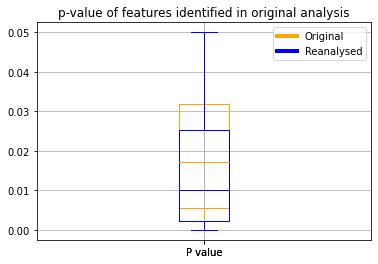

In [4]:
# our highly correlating features matching original differential analysis
prot_tran_data = prot_tran_index.merge(features, left_on=0, right_on=0)
prot_tran = pd.concat([prot, tran])
prot_tran_data = prot_tran_data.merge(prot_tran, left_on=0, right_index=True)
prot_tran_data.set_index(0, inplace=True)
prot_tran_data
prot_tran = prot.melt()
prot_tran.columns = ["index", "P value"]
prot_tran.boxplot(color="orange", showfliers=True)
prot_tran_data = prot_tran_data.melt()
prot_tran_data.columns = ["index", "P value"]
prot_tran_data.boxplot(color="blue", showbox=True, showfliers=True)
plt.title("p-value of features identified in original analysis")
custom_lines = [Line2D([0], [0], color="orange", lw=4),
                Line2D([0], [0], color="blue", lw=4)]
plt.legend(custom_lines, ["Original", "Reanalysed"])
percent_significant = str(int(feat_count) /
                          (int(prot_count) + int(tran_count)) *
                          100)
print("".join(["Features below a p value of 0.05 in original analysis (of all features)=",
              percent_significant, " %"]))
print("Blue = our features: 170 | Orange = authors features: 2957")

In [5]:
# examine annotated significant features overlapping with original study
x = data[data.columns[1:4]]
x.columns = ["id", "name", "annot"]
y = data[data.columns[5:8]]
y.columns = ["id", "name", "annot"]
annot = pd.concat([x, y]).set_index("id")
annot = features.merge(annot, left_on=0, right_index=True)
annot.drop_duplicates()

,0,name,annot
0,Q7Z2T5,NaN,NaN
1,A6NHR9,NaN,NaN
2,P31321,PRKAR1B,cAMP-dependent protein kinase type I-beta regu...
3,Q16719,KYNU,Kynureninase;KYNU;ortholog
4,P0DTC6,NaN,Non-structural protein 6 (ns6) (Accessory prot...
...,...,...,...
164,P28370,NaN,NaN
165,Q96A33,NaN,NaN
166,O75116,ROCK2,Rho-associated protein kinase 2;ROCK2;ortholog
168,Q9NQG5,RPRD1B,Regulation of nuclear pre-mRNA domain-containi...
